# Data Science Honors Thesis

## Install Packages

In [1]:
# install and import packages
!pip install xmltodict

import pandas as pd
import numpy as np

## Acquiring Data

In [2]:
# function from Chen & Sohn
import xmltodict

def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
        xml.close()
    return report_dict

In [3]:
# an example of report file
reportdict_1 = xml_parse("./ecgen-radiology/1390.xml")
reportdict_1

{'eCitation': {'meta': {'@type': 'rr'},
  'uId': {'@id': 'CXR1390'},
  'pmcId': {'@id': '1390'},
  'docSource': 'CXR',
  'IUXRId': {'@id': '1390'},
  'licenseType': 'open-access',
  'licenseURL': 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
  'ccLicense': 'byncnd',
  'articleURL': None,
  'articleDate': '2013-08-01',
  'articleType': 'XR',
  'publisher': 'Indiana University',
  'title': 'Indiana University Chest X-ray Collection',
  'note': 'The data are drawn from multiple hospital systems.',
  'specialty': 'pulmonary diseases',
  'subset': 'CXR',
  'MedlineCitation': {'@Owner': 'Indiana University',
   '@Status': 'supplied by publisher',
   'Article': {'@PubModel': 'Electronic',
    'Journal': {'JournalIssue': {'PubDate': {'Year': '2013',
       'Month': '08',
       'Day': '01'}}},
    'ArticleTitle': 'Indiana University Chest X-ray Collection',
    'Abstract': {'AbstractText': [{'@Label': 'COMPARISON', '#text': 'None'},
      {'@Label': 'INDICATION', '#text': 'Slipped , XXX

In [4]:
# functions adapted from Chen & Sohn
def get_label(report):
    label = report['eCitation']['MeSH']['major']
    return 'normal' if label == 'normal' or label == "No Indexing" else 'abnormal'

def get_text(report):
    text_dict = {}
    text_dict['id'] = report['eCitation']['IUXRId']['@id']
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['findings'], text_dict['impression']= findings, impression
    text_dict['full-text'] = ' '.join([findings, impression])
    return text_dict

def get_image(report):
    image_dict = {}
    image_dict['id'] = report['eCitation']['IUXRId']['@id']
    try:
        images = report['eCitation']['parentImage']
        images = [images] if isinstance(images, dict) else images
        for image in images:
            if len(images) > 1:
                image_dict.setdefault('image_id',[])
            image_dict['image_id'].append('NLMCXR_png/'+image['@id']+'.png')
    except KeyError:
        images = None
    return image_dict

def process_report(report,image=True):
    if image:
        report_dict = get_image(report)
    else:
        report_dict = get_text(report)
    report_dict['label'] = get_label(report)
    return report_dict

In [5]:
import glob

files = glob.glob("./ecgen-radiology/*")
reports, images = list(), list()

for file in files:
    report_extract = xml_parse(file)
    reports.append(process_report(report_extract,image=False))
    images.append(process_report(report_extract,image=True))

reports_df, images_df = pd.DataFrame(reports), pd.DataFrame(images)
images_df = images_df.explode('image_id').reset_index()

In [6]:
print("# of reports:",reports_df.shape[0])
pd.options.display.max_colwidth = 0
reports_df.sample(5)

# of reports: 3955


,id,findings,impression,full-text,label
3352,753,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There are mild degenerative changes of the spine.",No acute cardiopulmonary disease.,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There are mild degenerative changes of the spine. No acute cardiopulmonary disease.",abnormal
3489,3563,,No comparison chest x-XXXX. No evidence of active tuberculosis. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,No comparison chest x-XXXX. No evidence of active tuberculosis. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,normal
2281,1919,"Hyperexpansion of the lungs with hyperlucency and flattening of hemidiaphragms suggestive of chronic emphysematous lung disease. Heart size within normal limits. Bibasilar, right greater than left atelectasis/airspace disease noted. No pneumothorax or large pleural effusion. No acute bony abnormality.","Chronic emphysematous lung disease with mild bibasilar, right greater than left airspace disease/atelectasis.","Hyperexpansion of the lungs with hyperlucency and flattening of hemidiaphragms suggestive of chronic emphysematous lung disease. Heart size within normal limits. Bibasilar, right greater than left atelectasis/airspace disease noted. No pneumothorax or large pleural effusion. No acute bony abnormality. Chronic emphysematous lung disease with mild bibasilar, right greater than left airspace disease/atelectasis.",abnormal
2783,3649,Clear lungs bilaterally. No pneumothorax or large pleural effusion. Normal cardiac contour.,1. No acute cardiopulmonary abnormality.,Clear lungs bilaterally. No pneumothorax or large pleural effusion. Normal cardiac contour. 1. No acute cardiopulmonary abnormality.,normal
2670,3930,Lungs are overall hyperexpanded consistent with obstructive lung disease. Lungs are clear without focal consolidation. No suspicious pulmonary nodules or masses are noted. No pleural effusions or pneumothoraces. heart size is upper limits of normal.,Hyperexpanded but clear lungs.,Lungs are overall hyperexpanded consistent with obstructive lung disease. Lungs are clear without focal consolidation. No suspicious pulmonary nodules or masses are noted. No pleural effusions or pneumothoraces. heart size is upper limits of normal. Hyperexpanded but clear lungs.,abnormal


In [7]:
print("# of images:",images_df.shape[0])
pd.options.display.max_colwidth = 0
images_df.head()

# of images: 7574


,index,id,image_id,label
0,0,162,NLMCXR_png/CXR162_IM-0401-1001.png,normal
1,0,162,NLMCXR_png/CXR162_IM-0401-2001.png,normal
2,1,1390,NLMCXR_png/CXR1390_IM-0249-1001.png,abnormal
3,1,1390,NLMCXR_png/CXR1390_IM-0249-2001.png,abnormal
4,2,604,NLMCXR_png/CXR604_IM-2193-1001.png,abnormal


## EDA

Impression: No acute cardiopulmonary abnormality identified.


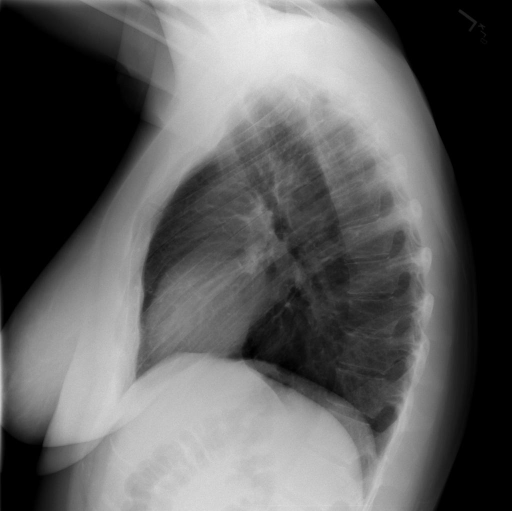

In [8]:
# An example of a radiology image that is normal
from PIL import Image
from IPython.display import display

# Load image from file
normal = images_df[images_df['label']=='normal'].sample(1).iloc[0]
image_path = normal['image_id']
image = Image.open(image_path)
impression = reports_df[reports_df['id']==normal['id']]['impression'].iloc[0]
print('Impression:',impression)

# Display the image
display(image)

Impression: No acute disease.


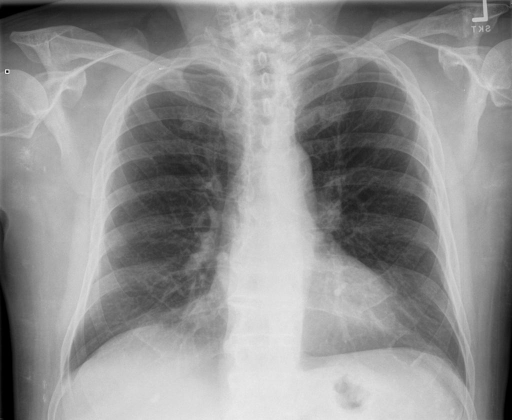

In [9]:
# An example of a radiology image that is abnormal

# Load image from file
abnormal = images_df[images_df['label']=='abnormal'].sample(1).iloc[0]
image_path = abnormal['image_id']
image = Image.open(image_path)
impression = reports_df[reports_df['id']==abnormal['id']]['impression'].iloc[0]
print('Impression:',impression)

# Display the image
display(image)

Abnormal: 2469
Normal: 1486


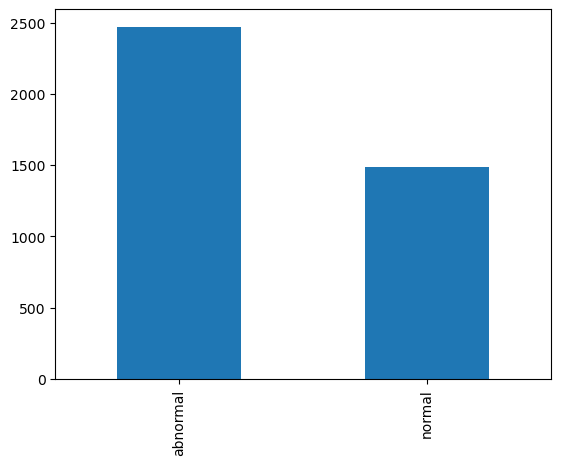

In [10]:
label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
label_counts.plot.bar();

## ResNet Image Classification

In [ ]:
import torch
import torchvision

# Load a pre-trained ResNet-50 model
model = torchvision.models.resnet50(pretrained=True)

In [ ]:
num_classes = 2

# Modify the output layer
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes)

In [ ]:
import torch.optim as optim

# Load your image data using DataLoader
train_loader = 
val_loader = ...

# Define a loss function and an optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Iterate over the training data in batches
    for images, labels in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Compute the backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

    # Evaluate the model on the validation data
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()

        # Compute the validation loss and accuracy
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        for images, labels in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total

        print(f"Epoch {epoch+1}: val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}")